In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
# pd.options.display.max_rows = 30
# pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
from IPython.display import Image, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
## Copy paste

%run login.py

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""

import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})

token = mylogin.json()['data']['logIn']['jwt']['token']

device_ids = ['SWLSANDBOX1', 'SWLSANDBOX2', 'SWLSANDBOX3']

In [4]:
def text_explaination(camera, zone, function, procedure):
    print('This {0} behavior zone is under {1} camera. It servers for {2}.\nWe will explore this zone through {3}.'
          .format(zone, camera, function, procedure))

In [5]:
fdir = 'BehaviorZoneImage/'
@interact
def show_images(Zone=os.listdir(fdir)):
    display(Image(fdir+Zone))
    if (Zone == 'Outside-ChairZone.png'):
            text_explaination('Outside', 'ChairZone', 'seating or taking a break for pedestrians', 'its desired spots')
    if (Zone == 'Outside-PathZone.png'):
            text_explaination('Outside', 'PathZone', 'path for pedestrians, vehicles, bikes', 'desired lines and spots for pedastrains and traffics')
    if (Zone == 'Streetscape-PathZone.png'):
            text_explaination('Streetscape', 'PathZone', 'path for pedestrians', 'desired line and spots for pedastrains')
    if (Zone == 'Streetscape-ChairZone.png'):
            text_explaination('Streetscape', 'ChairZone', 'activity seating or taking a break for pedestrians', 'its desired spots')
    if (Zone == 'Streetscape-ActivityZone.png'):
            text_explaination('Streetscape', 'ActivityZone', 'freely walking for pedastrains or holding activities', 'its desired spots, lines')
    if (Zone == 'UnderRaincoat-TrafficZone.png'):
            text_explaination('UnderRaincoat', 'TrafficZone', 'path for pedestrians, vehicles, bikes', 'its desired spots, lines for pedastrains and traffics')
    if (Zone == 'UnderRaincoat-ChairZone.png'):
            text_explaination('UnderRaincoat', 'ChairZone', 'factivity seating or taking a break for pedestrians', 'its desired spots')
    if (Zone == 'UnderRaincoat-ActivityZone.png'):
            text_explaination('UnderRaincoat', 'ActivityZone', 'freely walking for pedastrains', 'its desired spots, lines')

interactive(children=(Dropdown(description='Zone', options=('Outside-ChairZone.png', 'Outside-PathZone.png', '…


**This is for keeping track of my work**
1. Get zones ids, store them
2. Zone heatmap based on day of all zones, store them in csv
3. Interaction for path zone: we do not use rectangle, because it has angle, so visualize, interative part, date, quantile, types

In [6]:
## copy and paste
def get_zones(device_id):
    query_zones = """
    query {{
      behaviorZones (
        serialnos: "{0}"
        ) {{
        count
        edges {{
          node {{
            rawId
            
            text
          }}
        }}
      }}
    }}
    """.format(device_id)
    
    zones = requests.post(url, json={'query': query_zones}, headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in zones.json()['data']['behaviorZones']['edges']])
    df['device'] = device_id
    
    return df

In [7]:
zones_df = pd.concat([get_zones(device_ids[i]) for i in range(3)])

In [8]:
## get our gourp zone
x_zones_df = zones_df[zones_df['text'].apply(lambda x: True if (x is not None and x[0:2] == 'x-') else False)]
x_zones_id = list(x_zones_df['rawId'])

In [9]:
x_zones_df

,rawId,text,device
3873,14895,x-streetscape-corridorzone,SWLSANDBOX1
3874,14896,x-streetscape-chairzone,SWLSANDBOX1
3875,14897,x-streetscape-freezone,SWLSANDBOX1
3925,14898,x-underraincoat-trafficzone,SWLSANDBOX2
3926,14899,x-underraincoat-freezone,SWLSANDBOX2
3927,14900,x-underraincoat-chairzone1,SWLSANDBOX2
3928,14901,x-underraincoat-chairzone2,SWLSANDBOX2
3929,14902,x-underraincoat-chairzone3,SWLSANDBOX2
3994,14893,x-outside-chairzone,SWLSANDBOX3
3995,14894,x-outside-pathzone,SWLSANDBOX3


In [10]:
## please do not input mutiple zoneId or obj, you can always use a for loop to construct a dataframe with multiple objects
def zone_heatmap_query_gen(startTime: str, endTime: str, zoneId: int, obj =str):
    zoneId = str(zoneId)
    heatmap_query = """
query {{
    zoneHeatmaps(
    zoneIds: [{0}],
    startTime:"{1}",
    endTime:"{2}",
    objClasses:["{3}"],
    timezone:"America/New_York") {{
    edges {{
        node {{
        time
        objClass
        heatmap
      }}
    }}
  }}
}}
""".format(zoneId, startTime, endTime, obj)
    return heatmap_query

In [47]:
def heatmap_query_gen(startTime: str, endTime: str, camera:int, obj:str):
    heatmap_query = """
query {{
  feedHeatmaps(
    serialno: "{0}",
    startTime:"{1}",
    endTime:"{2}",
    objClasses:["{3}"],
    timezone:"America/New_York") {{
    edges {{
      node {{
        time
        objClass
        heatmap
      }}
    }}
  }}
}}
""".format(camera, startTime, endTime,obj)
    return heatmap_query

In [11]:
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import calendar
START_DATE = datetime(2019, 2, 20, 0, 0, 0)
END_DATE = datetime(2020, 1, 11, 0, 0, 0)
time_delta = relativedelta(days = +1)

In [12]:
##heatmap_data = requests.post(url, json={'query': zone_heatmap_query_gen(start_time_str, end_time_str, '14895', 'pedestrian')}, 
##                         headers = {'Authorization':token})
## This is an example in case I forgot

In [13]:
## start_times and end_times are required to have same length
def get_zoneheatmap_data(zoneid: int, obj: str, start_times: list, end_times: list):
    zone_heatmap_df = pd.DataFrame(columns = ['startTime', 'endTime', 'heatMap', 'obj'])
    i = 0
    while i < len(start_times):
        heatmap_data = requests.post(url, json={'query': zone_heatmap_query_gen(start_times[i].strftime('%Y-%m-%dT%H:%M:%S'), 
                                                                                end_times[i].strftime('%Y-%m-%dT%H:%M:%S'), zoneid, obj)}, 
                                                                                headers = {'Authorization':token})
        heatmap_json = heatmap_data.json()
        if heatmap_json['data']:
            if 'zoneHeatmaps' in heatmap_json['data']:
                heatmap = heatmap_json['data']['zoneHeatmaps']['edges'][0]['node']['heatmap']
                temp_df = pd.DataFrame({"startTime":start_times[i], "endTime":end_times[i], 'heatMap':heatmap, 'obj': obj})
                zone_heatmap_df = zone_heatmap_df.append(temp_df, ignore_index = True)
        i = i + 1
    return zone_heatmap_df

In [51]:
def get_heatmap_data(camera: int, obj: str, start_times:list, end_times:list):
    heatmap_df = pd.DataFrame(columns = ['startTime', 'endTime', 'heatMap', 'obj'])
    i = 0
    while i < len(start_times):
        heatmap_data = requests.post(url, json={'query': heatmap_query_gen(start_times[i].strftime('%Y-%m-%dT%H:%M:%S'), 
                                                                                end_times[i].strftime('%Y-%m-%dT%H:%M:%S'), camera, obj)}, 
                                                                                headers = {'Authorization':token})
        heatmap_json = heatmap_data.json()
        if heatmap_json['data']:
            if 'feedHeatmaps' in heatmap_json['data']:
                heatmap = heatmap_json['data']['feedHeatmaps']['edges'][0]['node']['heatmap']
                temp_df = pd.DataFrame({"startTime":start_times[i], "endTime":end_times[i], 'heatMap':heatmap, 'obj': obj})
                heatmap_df = heatmap_df.append(temp_df, ignore_index = True)
        i = i + 1
    return heatmap_df

In [45]:
def generate_consecutive_times(start_time: datetime, end_time: datetime, interval: relativedelta):
    ## the first element in the list are the start times
    time = [[], []]
    current_time = start_time
    while current_time < end_time:
        time[0].append(current_time)
        time[1].append(current_time + interval)
        current_time = current_time + interval
    return time

In [15]:
def daily_heatmap_data(df):
    return df.groupby(['startTime', 'endTime'])['heatMap'].apply(list).reset_index(name='heatMapMatrix')

In [16]:
all_time = generate_consecutive_times(START_DATE, END_DATE, time_delta)

In [17]:
## streetscape_corridorzone_heatmap_pedestrian.to_csv('streetscape_corridorzone_heatmap_pedestrian', encoding='utf-8', index=False)
## streetscape_freezone_heatmap_pedestrian.to_csv('streetscape_freezone_heatmap_pedestrian', encoding='utf-8', index=False)

In [19]:
streetscape_corridorzone_heatmap_pedestrian_0 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[0], 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [21]:
streetscape_corridorzone_heatmap_pedestrian_1 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[0], 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [23]:
streetscape_corridorzone_heatmap_pedestrian_2 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[0], 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [24]:
streetscape_corridorzone_heatmap_pedestrian = streetscape_corridorzone_heatmap_pedestrian_0.append(streetscape_corridorzone_heatmap_pedestrian_1).append(streetscape_corridorzone_heatmap_pedestrian_2)

In [25]:
streetscape_corridorzone_heatmap_pedestrian = streetscape_corridorzone_heatmap_pedestrian.reset_index(drop = True)

In [26]:
streetscape_freezone_heatmap_pedestrian_0 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[2], 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [28]:
streetscape_freezone_heatmap_pedestrian_1 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[2], 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [30]:
streetscape_freezone_heatmap_pedestrian_2 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[2], 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [39]:
streetscape_freezone_heatmap_pedestrian = streetscape_freezone_heatmap_pedestrian_0.append(streetscape_freezone_heatmap_pedestrian_1).append(streetscape_freezone_heatmap_pedestrian_2)

In [40]:
streetscape_freezone_heatmap_pedestrian = streetscape_freezone_heatmap_pedestrian.reset_index(drop = True)

In [55]:
streetscape_heatmap_pedestrian_0 = daily_heatmap_data((get_heatmap_data('SWLSANDBOX1', 'pedestrian', all_time[0][0:100], all_time[1][0:100])))

In [57]:
streetscape_heatmap_pedestrian_1 = daily_heatmap_data((get_heatmap_data('SWLSANDBOX1', 'pedestrian', all_time[0][100:200], all_time[1][100:200])))

In [59]:
streetscape_heatmap_pedestrian_2 = daily_heatmap_data((get_heatmap_data('SWLSANDBOX1', 'pedestrian', all_time[0][200:], all_time[1][200:])))

In [60]:
streetscape_heatmap_pedestrian = streetscape_heatmap_pedestrian_0.append(streetscape_heatmap_pedestrian_1).append(streetscape_heatmap_pedestrian_2)

In [61]:
streetscape_heatmap_pedestrian = streetscape_heatmap_pedestrian.reset_index(drop = True)

Now, I am going to create interative page for activity zone as an example 
interactive part: 
1. gradient, heatmap,
2. choose date
3. choose quantile
4. choose blur
5. Show connected components

In [188]:
def plot_streetscape_heatmap(date, quantile, zone, colormap):
    fig, ax = plt.subplots(figsize=(15,10))
    if colormap == 'Warm':
        cmap = plt.cm.nipy_spectral
    if colormap == 'Cold':
        cmap = plt.cm.YlGnBu_r
    if zone == 'Streetscape Corridor Zone':
        map_img = mpimg.imread('BehaviorZoneImage/Streetscape-PathZone.png')
        if list(streetscape_corridorzone_heatmap_pedestrian[streetscape_corridorzone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix']):
            matrix = streetscape_corridorzone_heatmap_pedestrian[streetscape_corridorzone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix'][0]
            p = np.percentile([i[2] for i in matrix], quantile)
            filtered = list(filter(lambda x : x[2] >= p, matrix))
            x = [i[0] for i in filtered] 
            y = [i[1] for i in filtered]
            density = [i[2] for i in filtered]
            im = ax.scatter(x, y, c=density, s=1, cmap=cmap) # Other color maps: plt.cm.cmap_d.keys())
    if zone == 'Streetscape Free Zone':
        map_img = mpimg.imread('BehaviorZoneImage/Streetscape-ActivityZone.png')
        if list(streetscape_freezone_heatmap_pedestrian[streetscape_freezone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix']):
            matrix = streetscape_freezone_heatmap_pedestrian[streetscape_freezone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix'][0]
            p = np.percentile([i[2] for i in matrix], quantile)
            filtered = list(filter(lambda x : x[2] >= p, matrix))
            x = [i[0] for i in filtered] 
            y = [i[1] for i in filtered]
            density = [i[2] for i in filtered]
            im = ax.scatter(x, y, c=density, s=1, cmap=cmap) # Other color maps: plt.cm.cmap_d.keys()) nipy_spectral
    if zone == 'The Whole Camera':
        map_img = mpimg.imread('./streetscape_sandbox.png')
        if list(streetscape_heatmap_pedestrian[streetscape_heatmap_pedestrian['startTime'] == date]['heatMapMatrix']):
            matrix = streetscape_heatmap_pedestrian[streetscape_heatmap_pedestrian['startTime'] == date]['heatMapMatrix'][0]
            p = np.percentile([i[2] for i in matrix], quantile)
            filtered = list(filter(lambda x : x[2] >= p, matrix))
            x = [i[0] for i in filtered] 
            y = [i[1] for i in filtered]
            density = [i[2] for i in filtered]
            im = ax.scatter(x, y, c=density, s=1, cmap=cmap)# Other color maps: plt.cm.cmap_d.keys()) nipy_spectral
    ax.imshow(map_img, aspect='auto')
    plt.axis('off')
    plt.title("Heatmap Visualization for {0}".format(zone), fontsize=20)
        
widgets.interact(plot_streetscape_heatmap, date=widgets.DatePicker(value=pd.to_datetime('2019-2-20')), 
                 zone = widgets.Dropdown(options=['Streetscape Corridor Zone', 'Streetscape Free Zone', 'The Whole Camera']),
                 quantile = widgets.IntSlider(min=0, max=100, step=10, value=0),
                colormap =  widgets.Dropdown(options=['Warm', 'Cold']))
## do we have autoplay slider?

interactive(children=(DatePicker(value=Timestamp('2019-02-20 00:00:00'), description='date'), IntSlider(value=…

<function __main__.plot_streetscape_heatmap(date, quantile, zone, colormap)>

In [ ]:
## Deal with outside camera
## 1. load the data for all types of users
## 2. Plot the heatmap

In [75]:
outside_pathzone_heatmap_pedestrian_0 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-1], 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [77]:
outside_pathzone_heatmap_pedestrian_1 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-1], 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [82]:
outside_pathzone_heatmap_pedestrian_2 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-1], 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [157]:
outside_chairzone_heatmap_pedestrian_0 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-2], 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [158]:
outside_chairzone_heatmap_pedestrian_1 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-2], 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [159]:
outside_chairzone_heatmap_pedestrian_2 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-2], 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [85]:
outside_pathzone_heatmap_car_0 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-1], 'car', all_time[0][0:100], all_time[1][0:100]))

In [87]:
outside_pathzone_heatmap_car_1 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-1], 'car', all_time[0][100:200], all_time[1][100:200]))

In [88]:
outside_pathzone_heatmap_car_2 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[-1], 'car', all_time[0][200:], all_time[1][200:]))

In [163]:
outside_heatmap_pedestrian_0 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [162]:
outside_heatmap_pedestrian_1 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [164]:
outside_heatmap_pedestrian_2 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [ ]:
outside_heatmap_car = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'car', all_time[0], all_time[1]))

In [171]:
underraincoat_pathzone_heatmap_pedestrian_0 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[3], 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [172]:
underraincoat_pathzone_heatmap_pedestrian_1 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[3], 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [173]:
underraincoat_pathzone_heatmap_pedestrian_2 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[3], 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [ ]:
underraincoat_pathzone_heatmap_car_0 = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[3], 'car', all_time[0], all_time[1]))

In [ ]:
underraincoat_activityzone_heatmap_pedestrian = daily_heatmap_data(get_zoneheatmap_data(x_zones_id[3], 'pedestrian', all_time[0], all_time[1]))

In [ ]:
outside_chairzone_heatmap_pedestrian = outside_chairzone_heatmap_pedestrian_0.append(outside_chairzone_heatmap_pedestrian_1).append(outside_chairzone_heatmap_pedestrian_2)
outside_chairzone_heatmap_pedestrian = outside_chairzone_heatmap_pedestrian.reset_index(drop = True)
outside_heatmap_pedestrian = outside_heatmap_pedestrian_0.append(outside_heatmap_pedestrian_1).append(outside_heatmap_pedestrian_2)
outside_heatmap_pedestrian = outside_chairzone_heatmap_pedestrian.reset_index(drop = True)

In [178]:
underraincoat_pathzone_heatmap_pedestrian = underraincoat_pathzone_heatmap_pedestrian_0.append(underraincoat_pathzone_heatmap_pedestrian_1).append(underraincoat_pathzone_heatmap_pedestrian_2)
underraincoat_pathzone_heatmap_pedestrian = underraincoat_pathzone_heatmap_pedestrian.reset_index(drop = True)

In [99]:
outside_pathzone_heatmap_pedestrian = outside_pathzone_heatmap_pedestrian_0.append(outside_pathzone_heatmap_pedestrian_1).append(outside_pathzone_heatmap_pedestrian_2)
outside_pathzone_heatmap_pedestrian = outside_pathzone_heatmap_pedestrian.reset_index(drop = True)
outside_pathzone_heatmap_car = outside_pathzone_heatmap_car_0.append(outside_pathzone_heatmap_car_1).append(outside_pathzone_heatmap_car_2)
outside_pathzone_heatmap_car = outside_pathzone_heatmap_car.reset_index(drop = True)

In [186]:
def plot_outside_heatmap(date, quantile, zone, colormap, traffic = True, bicycle =True):
    fig, ax = plt.subplots(figsize=(15,10))
    if colormap == 'Warm':
        cmap = plt.cm.nipy_spectral
        traffic_heatmap = plt.cm.YlGnBu_r
    if colormap == 'Cold':
        cmap = plt.cm.YlGnBu_r
        traffic_heatmap = plt.cm.nipy_spectral
    if zone == 'Outside Path Zone':
        map_img = mpimg.imread('BehaviorZoneImage/Outside-PathZone.png')
        if list(outside_pathzone_heatmap_pedestrian[outside_pathzone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix']):
            matrix = list(outside_pathzone_heatmap_pedestrian[outside_pathzone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix'])[0]
            p = np.percentile([i[2] for i in matrix], quantile)
            filtered = list(filter(lambda x : x[2] >= p, matrix))
            x = [i[0] for i in filtered] 
            y = [i[1] for i in filtered]
            density = [i[2] for i in filtered]
            im = ax.scatter(x, y, c=density, s=1, cmap=cmap) # Other color maps: plt.cm.cmap_d.keys())
        if traffic == True:
            if list(outside_pathzone_heatmap_car[outside_pathzone_heatmap_car['startTime'] == date]['heatMapMatrix']):
                traffic_matrix = list(outside_pathzone_heatmap_car[outside_pathzone_heatmap_car['startTime'] == date]['heatMapMatrix'])[0]
                x = [i[0] for i in traffic_matrix] 
                y = [i[1] for i in traffic_matrix]
                density = [i[2] for i in traffic_matrix]
                ax.scatter(x, y, c=density, s=1, cmap=traffic_heatmap)
    if zone == 'Outside Chair Zone':
        map_img = mpimg.imread('BehaviorZoneImage/Outside-ChairZone.png')
        if  list(outside_chairzone_heatmap_pedestrian[outside_chairzone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix']):
            matrix = list(outside_chairzone_heatmap_pedestrian[outside_chairzone_heatmap_pedestrian['startTime'] == date]['heatMapMatrix'])[0]
            x = [i[0] for i in matrix] 
            y = [i[1] for i in matrix]
            density = [i[2] for i in matrix]
            ax.scatter(x, y, c=density, s=1, cmap=cmap)
    if zone == 'The Whole Camera':
        map_img = mpimg.imread('outside_sandbox.png')
        if list(outside_heatmap_pedestrian[outside_heatmap_pedestrian['startTime'] == date]['heatMapMatrix']):
            matrix = list(outside_heatmap_pedestrian[outside_heatmap_pedestrian['startTime'] == date]['heatMapMatrix'])[0]
            p = np.percentile([i[2] for i in matrix], quantile)
            filtered = list(filter(lambda x : x[2] >= p, matrix))
            x = [i[0] for i in filtered] 
            y = [i[1] for i in filtered]
            density = [i[2] for i in filtered]
            im = ax.scatter(x, y, c=density, s=1, cmap=cmap)
            if traffic == True:
                if list(outside_pathzone_heatmap_car[outside_pathzone_heatmap_car['startTime'] == date]['heatMapMatrix']):
                    traffic_matrix = list(outside_pathzone_heatmap_car[outside_pathzone_heatmap_car['startTime'] == date]['heatMapMatrix'])[0]
                    x = [i[0] for i in traffic_matrix] 
                    y = [i[1] for i in traffic_matrix]
                    density = [i[2] for i in traffic_matrix]
                    ax.scatter(x, y, c=density, s=1, cmap=traffic_heatmap)
    ax.imshow(map_img, aspect='auto')
    plt.axis('off')
    plt.title("Heatmap Visualization for {0}".format(zone), fontsize=20)
widgets.interact(plot_outside_heatmap, date=widgets.DatePicker(value=pd.to_datetime('2019-6-29')), 
                 zone = widgets.Dropdown(options=['Outside Path Zone', 'Outside Chair Zone', 'The Whole Camera']),
                 quantile = widgets.IntSlider(min=0, max=100, step=10, value=0),
                colormap =  widgets.Dropdown(options=['Warm', 'Cold'],
                traffic = widgets.Checkbox(description='Show Traffic Heatmap'),
                 bicycle = widgets.Checkbox(description='Show Traffic Heatmap')))

interactive(children=(DatePicker(value=Timestamp('2019-06-29 00:00:00'), description='date'), IntSlider(value=…

<function __main__.plot_outside_heatmap(date, quantile, zone, colormap, traffic=True, bicycle=True)>

In [ ]:
def plot_underraincoat_heatmap(date, quantile, zone, colormap, traffic = True, bicycle =True):
    if colormap == 'Warm':
        cmap = plt.cm.nipy_spectral
        traffic_heatmap = plt.cm.YlGnBu_r
    if colormap == 'Cold':
        cmap = plt.cm.YlGnBu_r
        traffic_heatmap = plt.cm.nipy_spectral
    if zone == 'Under Raincoat Path Zone':
         map_img = mpimg.imread('BehaviorZoneImage/UnderRaincoat-TrafficZone.png') 
    if zone == 'Under Raincoat Free Zone':
         map_img = mpimg.imread('BehaviorZoneImage/UnderRaincoat-ActivityZone.png')
    if zone == 'The Whole Camera':
         map_img = mpimg.imread('BehaviorZoneImage/Outside-PathZone.png')

## Above is the current progress

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



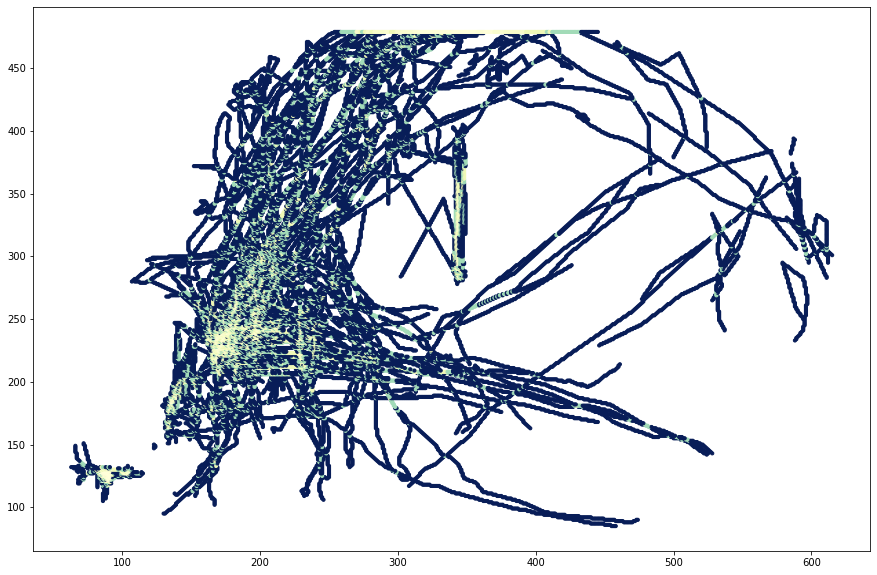

In [176]:
## This is an experiment for image manipulation
matrix = streetscape_corridorzone_heatmap_pedestrian.loc[0,'heatMapMatrix']
x = [i[0] for i in matrix] 
y = [i[1] for i in matrix]
density = [i[2] for i in matrix]
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y, c=density, s=10, cmap=plt.cm.YlGnBu_r) # Other color maps: plt.cm.cmap_d.keys())
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

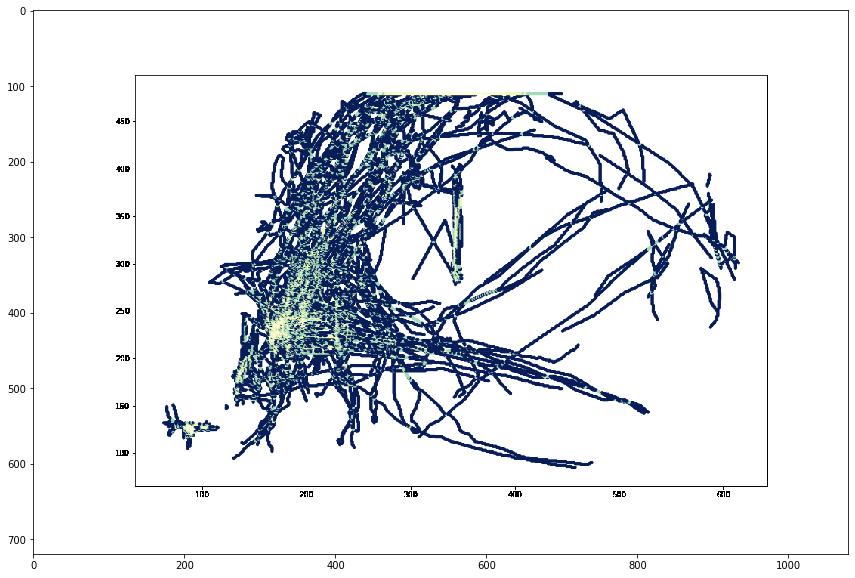

In [177]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(data)

<Figure size 1080x720 with 0 Axes>

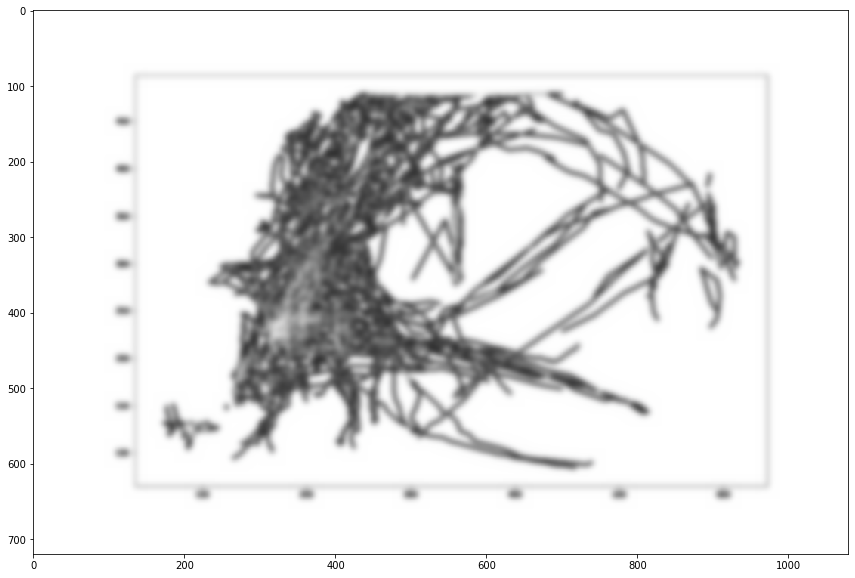

In [168]:
## blur
from scipy import ndimage
ok = ndimage.gaussian_filter(data, sigma=4)
plt.figure(figsize=(15, 10))
plt.imshow(ok)

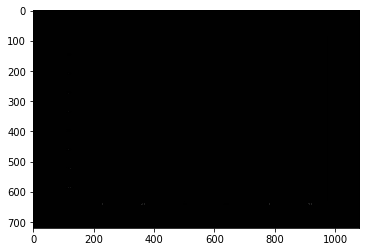

In [179]:
## detect connected region
label_im, nb_labels = ndimage.label(data)
plt.imshow(label_im) 

In [143]:
sizes = ndimage.sum(data, label_im, range(nb_labels + 1))

In [165]:
## mean_vals = ndimage.sum(im, label_im, range(1, nb_labels + 1))

<Figure size 1080x720 with 0 Axes>

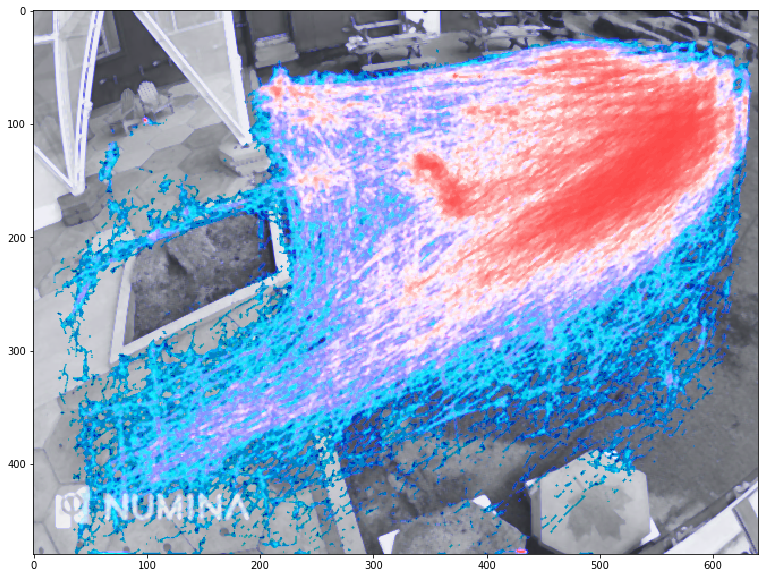

In [181]:
test = plt.imread('test_connected_component.png')
img2 = test.copy()     # Copy the image.
img2[img2 < 128] = 0   # Set all values less than 128 to 0 (black).
img2[img2 >= 128] = 255   # Set all values equal or greater than 128 to 255 (white).
lbl, n = ndimage.label(img2)
nmsl = ndimage.median_filter(test, 3)
plt.figure(figsize=(15, 10))
plt.imshow(nmsl)

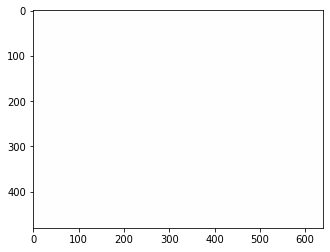

In [159]:
label_im, nb_labels = ndimage.label(test)
plt.imshow(label_im) 

In [162]:
sx = ndimage.sobel(test, axis=0, mode='constant')
sy = ndimage.sobel(test, axis=1, mode='constant')
sob = np.hypot(sx, sy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


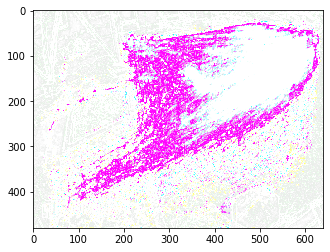

In [164]:
plt.imshow(sob) 

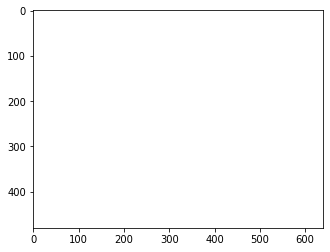

In [184]:
plt.imshow(img2)

In [214]:
def zone_max_occu_query_gen(startTime: str, endTime: str, interval:str,  zoneId: int, obj =str):
    zoneId = str(zoneId)
    max_occu_query = """
query {{
    zoneMaxOccupancy(
    zoneIds: [{0}],
    startTime:"{1}",
    endTime:"{2}",
    interval: "{3}"
    objClasses:["{4}"],
    timezone:"America/New_York") {{
    edges {{
        node {{
        objClass
        result
        time
        left
        right
        top
        bottom
      }}
    }}
  }}
}}
""".format(zoneId, startTime, endTime,interval, obj)
    return max_occu_query

In [215]:
query_max_occu = zone_max_occu_query_gen(START_DATE.strftime('%Y-%m-%dT%H:%M:%S'),END_DATE.strftime('%Y-%m-%dT%H:%M:%S'), '1d', x_zones_id[0], 'pedestrian')

In [216]:
zone_max_occu = requests.post(url, json={'query': query_max_occu}, headers = {'Authorization':token})

In [219]:
def zoneDwellTimeDistribution_query_gen(startTime: str, endTime: str, zoneId: int, obj =str):
    zoneId = str(zoneId)
    zoneDwellTimeDistribution_query = """
query {{
    zoneDwellTimeDistribution(
    zoneIds: [{0}],
    startTime:"{1}",
    endTime:"{2}",
    objClasses:["{3}"],
    timezone:"America/New_York") {{
    edges {{
        node {{
        objClass
        pct100
        pct75
        pct50
        pct25
        mean
        count
      }}
    }}
  }}
}}
""".format(zoneId, startTime, endTime, obj)
    return zoneDwellTimeDistribution_query

In [221]:
query_dwell_zone = (zoneDwellTimeDistribution_query_gen(START_DATE.strftime('%Y-%m-%dT%H:%M:%S'),END_DATE.strftime('%Y-%m-%dT%H:%M:%S'), x_zones_id[0], 'pedestrian'))

In [224]:
dwell_zone_distr = requests.post(url, json={'query': query_dwell_zone}, headers = {'Authorization':token})